## Binary Classification: Titanic Dataset
https://www.kaggle.com/c/titanic







Dataset Information:



Attribute Information: (9 features and 1 class)

Variable Definition Key

    survival Survival 0 = No, 1 = Yes
    pclass Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd
    sex Sex
    Age Age in years
    sibsp # of siblings / spouses aboard the Titanic
    parch # of parents / children aboard the Titanic
    ticket Ticket number
    fare Passenger fare
    cabin Cabin number
    embarked Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton

Objective of this project



** Dataset Information: **

891 passenger information aboard the Titanic

** Attribute Information: (9 features and 1 class)**

- survival Survival 0 = No, 1 = Yes
- pclass Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd
- sex Sex
- Age Age in years
- sibsp # of siblings / spouses aboard the Titanic
- parch # of parents / children aboard the Titanic
- ticket Ticket number
- fare Passenger fare
- cabin Cabin number
- embarked Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton


** Objective of this project **

predict whether a passenger survived the sinking of the Titanic or not

## Data

In [1]:
import findspark
findspark.init('/home/danny/spark-2.2.1-bin-hadoop2.7')

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('titanic').getOrCreate()

In [2]:
# Load Data
df = spark.read.csv('titanic.csv',inferSchema=True,header=True)
# Inspect Data
df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [3]:
df.show(5)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
+-----------+--------+------+--------------------+------+----+-----+-----+------

In [4]:
df.head()

Row(PassengerId=1, Survived=0, Pclass=3, Name='Braund, Mr. Owen Harris', Sex='male', Age=22.0, SibSp=1, Parch=0, Ticket='A/5 21171', Fare=7.25, Cabin=None, Embarked='S')

In [5]:
df.describe().show()

+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|summary|      PassengerId|           Survived|            Pclass|                Name|   Sex|               Age|             SibSp|              Parch|            Ticket|             Fare|Cabin|Embarked|
+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|  count|              891|                891|               891|                 891|   891|               714|               891|                891|               891|              891|  204|     889|
|   mean|            446.0| 0.3838383838383838| 2.308641975308642|                null|  null| 29.69911764705882|0.5230078563411896|0.38159371492704824|260318.54916792738| 32.20420

## Data preprocessing

In [6]:
from pyspark.ml.feature import (StringIndexer,VectorAssembler,
                               OneHotEncoder,StringIndexer)
from pyspark.ml import Pipeline

** Clean Data **

In [7]:
df.columns

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [8]:
final_df = df.select(['Survived','Pclass','Sex',
                     'Age','SibSp','Parch',
                     'Fare','Embarked']).na.drop() 
final_df.show(2)

+--------+------+------+----+-----+-----+-------+--------+
|Survived|Pclass|   Sex| Age|SibSp|Parch|   Fare|Embarked|
+--------+------+------+----+-----+-----+-------+--------+
|       0|     3|  male|22.0|    1|    0|   7.25|       S|
|       1|     1|female|38.0|    1|    0|71.2833|       C|
+--------+------+------+----+-----+-----+-------+--------+
only showing top 2 rows



** Convert categorical to numeric **

In [9]:
# gender
gender_indexer = StringIndexer(inputCol='Sex',outputCol='SexIndex')
indexed = gender_indexer.fit(final_df).transform(final_df)
gender_encoder = OneHotEncoder(inputCol='SexIndex',outputCol='SexVec')
encoded = gender_encoder.transform(indexed)

In [10]:
# embark
embark_indexer = StringIndexer(inputCol='Embarked',outputCol='EmbarkIndex')
indexed = embark_indexer.fit(encoded).transform(encoded)
embark_encoder = OneHotEncoder(inputCol='EmbarkIndex',outputCol='EmbarkVec')
encoded = embark_encoder.transform(indexed)
#encoded.show(5)

** Split Features & Class (or target) **

In [11]:
# combine features into a single column
assembler = VectorAssembler(inputCols=['Pclass','SexVec','Age',
                                       'SibSp','Parch','Fare',
                                       'EmbarkVec'],outputCol='features')
output = assembler.transform(encoded )
#output.show(5)

# features and target
final_data = output.select('features','Survived')
final_data.show(5)

+--------------------+--------+
|            features|Survived|
+--------------------+--------+
|[3.0,1.0,22.0,1.0...|       0|
|[1.0,0.0,38.0,1.0...|       1|
|(8,[0,2,5,6],[3.0...|       1|
|[1.0,0.0,35.0,1.0...|       1|
|[3.0,1.0,35.0,0.0...|       0|
+--------------------+--------+
only showing top 5 rows



** Split Train Test sets **

In [12]:
seed = 101 #for reproducibility
train_data,test_data = final_data.randomSplit([0.7,0.3],seed=seed)
train_data.describe().show()
test_data.describe().show()

+-------+-------------------+
|summary|           Survived|
+-------+-------------------+
|  count|                506|
|   mean| 0.4189723320158103|
| stddev|0.49387910015468434|
|    min|                  0|
|    max|                  1|
+-------+-------------------+

+-------+-------------------+
|summary|           Survived|
+-------+-------------------+
|  count|                206|
|   mean|0.36893203883495146|
| stddev|0.48369091647024215|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



## Baseline Model

In [13]:
from pyspark.ml.classification import (LogisticRegression,LinearSVC,
                                        DecisionTreeClassifier,GBTClassifier,
                                        RandomForestClassifier,NaiveBayes)
from pyspark.ml.evaluation import BinaryClassificationEvaluator

#### Train Models

In [14]:
# Initialize multiple regressors
lrc = LogisticRegression(featuresCol='features', labelCol='Survived')
svc = LinearSVC(featuresCol='features', labelCol='Survived')
nbc = NaiveBayes(featuresCol='features', labelCol='Survived')
dtc = DecisionTreeClassifier(featuresCol='features', labelCol='Survived', seed=seed)
rfc = RandomForestClassifier(featuresCol='features', labelCol='Survived', seed=seed)
gbc = GBTClassifier(featuresCol='features', labelCol='Survived', seed=seed)

# Train the models 
lrc_model = lrc.fit(train_data)
svc_model = svc.fit(train_data)
nbc_model = nbc.fit(train_data)
dtc_model = dtc.fit(train_data)
rfc_model = rfc.fit(train_data)
gbc_model = gbc.fit(train_data)

#### Evaluate Models

In [15]:
# Make predictions
lrc_predictions = lrc_model.transform(test_data)
svc_predictions = svc_model.transform(test_data)
nbc_predictions = nbc_model.transform(test_data)
dtc_predictions = dtc_model.transform(test_data)
rfc_predictions = rfc_model.transform(test_data)
gbc_predictions = gbc_model.transform(test_data)

# Evaluate the models
auc_evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', 
                                              labelCol='Survived', 
                                              metricName='areaUnderROC')

print('\t\t\tArea Under ROC')
print('Logistic Regression:\t{:.3f}'.format(auc_evaluator.evaluate(lrc_predictions)))
print('Support Vector Machine\t{:.3f}'.format(auc_evaluator.evaluate(svc_predictions)))
print('Naive Bayes:\t\t{:.3f}'.format(auc_evaluator.evaluate(nbc_predictions)))
print('Decision Tree:\t\t{:.3f}'.format(auc_evaluator.evaluate(dtc_predictions)))
print('Random Forest:\t\t{:.3f}'.format(auc_evaluator.evaluate(rfc_predictions)))
print('Gradient Boosting Tree:\t{:.3f}'.format(auc_evaluator.evaluate(gbc_predictions)))

			Area Under ROC
Logistic Regression:	0.872
Support Vector Machine	0.863
Naive Bayes:		0.407
Decision Tree:		0.697
Random Forest:		0.869
Gradient Boosting Tree:	0.855


## Parameter tuning

#### Cross Validation

In [16]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# randomforest
model = LogisticRegression(featuresCol='features', labelCol='Survived')
# grid params
paramGrid = ParamGridBuilder() \
    .addGrid(model.regParam, [0.0, 0.2, 0.4]) \
    .addGrid(model.elasticNetParam, [0.0, 0.5 ,1.0]) \
    .build()
# cross validation
crossval = CrossValidator(estimator=model,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='Survived',
                                                              metricName='areaUnderROC'),
                          numFolds=2, # use 3+ folds in practice
                          seed=seed)
cvModel = crossval.fit(train_data)
# results
print(cvModel.avgMetrics)
print(cvModel.bestModel) #regParam=0, elasticNetParam=0

[0.8328702444138972, 0.8328702444138972, 0.8328702444138972, 0.8304679229963117, 0.8218402691597032, 0.7527433982897498, 0.8271547871149981, 0.7527433982897498, 0.5]
LogisticRegression_4689bb19e6378307a510


#### Evaluate the best model

In [18]:
# make predictions
predictions = cvModel.transform(test_data)
# calculate auc
print('\t\t\tArea Under ROC')
print('Logistic Regression:\t{:.3f}'.format(auc_evaluator.evaluate(predictions)))

			Area Under ROC
Logistic Regression:	0.872


## Final Model

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

In [20]:
# Train the model
classifier = LogisticRegression(featuresCol='features', labelCol='Survived', 
                      rawPredictionCol='rawPrediction', 
                      regParam=0.0, elasticNetParam=0.0)
final_model = classifier.fit(train_data)
# make predictions
predictions = final_model.transform(test_data)
predictions.show(10)

+--------------------+--------+--------------------+--------------------+----------+
|            features|Survived|       rawPrediction|         probability|prediction|
+--------------------+--------+--------------------+--------------------+----------+
|(8,[0,1,2,5],[3.0...|       0|[2.63535923735257...|[0.93310286074356...|       0.0|
|(8,[0,1,2,5],[3.0...|       0|[3.99628709116700...|[0.98194809251837...|       0.0|
|(8,[0,1,2,5],[3.0...|       0|[4.22310840013608...|[0.98555858426960...|       0.0|
|(8,[0,1,2,6],[1.0...|       0|[0.01029270015223...|[0.50257315232152...|       0.0|
|(8,[0,1,2,6],[3.0...|       0|[2.97607252937186...|[0.95148138247997...|       0.0|
|(8,[0,2,4,5],[3.0...|       0|[0.31454777260124...|[0.57799493092090...|       0.0|
|(8,[0,2,5],[2.0,3...|       1|[-1.2428296044650...|[0.22394383619363...|       1.0|
|(8,[0,2,5],[3.0,1...|       1|[-0.5390689911679...|[0.36840418521196...|       1.0|
|(8,[0,2,5,6],[1.0...|       1|[-2.8051697862880...|[0.0570454488

Area Under ROC:	0.872
Accuracy:	84.0%


             precision    recall  f1-score   support

          0       0.85      0.90      0.88       130
          1       0.81      0.74      0.77        76

avg / total       0.84      0.84      0.84       206



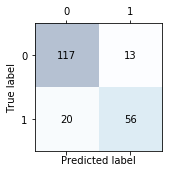

In [24]:
# Evaluate the model
df_pred = predictions.toPandas()

print('Area Under ROC:\t{:.3f}'.format(auc_evaluator.evaluate(predictions)))
print('Accuracy:\t{:0.1f}%'.format(100*accuracy_score(df_pred['Survived'],
                                                 df_pred['prediction'])))


#classification report
print('\n')
print(classification_report(df_pred['Survived'],df_pred['prediction']))

#confusion matrix
confmat = confusion_matrix(df_pred['Survived'],df_pred['prediction'])

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()


In [25]:
spark.stop()